# Homework 1 (HW1)

---
By the end of this homework we expect you to be able to:
1. Load data from different formats using [pandas](https://pandas.pydata.org/);
2. Navigate the documentation of Python packages by yourself;
3. Filter and tidy up noisy data sets;
4. Aggregate your data in different (and hopefully helpful) ways; 
5. Create meaningful visualizations to analyze the data;
6. Critically think and write about data;
---

## Important Dates

- Homework release: Fri 8 Oct 2021
- **Homework due**: Fri 22 Oct 2021, 23:59
- Grade release: Fri 29 Oct 2021

---

##  Some rules

1. You are allowed to use any built-in Python library that comes with Anaconda. If you want to use an external library, 
you may do so, but must justify your choice.
2. Make sure you use the `data` folder provided in the repository in read-only mode. (Or alternatively, be sure you 
don’t change any of the files.)
3. Be sure to provide a textual description of your thought process, the assumptions you made, the solution you 
implemented, and explanations for your answers. A notebook that only has code cells will not suffice.
4. For questions containing the **/Discuss:/** prefix, answer not with code, but with a textual explanation
 (**in markdown**).
5. Back up any hypotheses and claims with data, since this is an important aspect of the course.
6. Please write all your comments in English, and use meaningful variable names in your code. Your repo should have a 
single notebook (plus the required data files) in the *master/main* branch. If there are multiple notebooks present, 
we will **not grade** anything.
7. We will **not run your notebook for you**! Rather, we will grade it as is, which means that only the results 
contained in your evaluated code cells will be considered, and we will not see the results in unevaluated code cells. 
Thus, be sure to hand in a **fully-run and evaluated notebook**. In order to check whether everything looks as intended,
 you can check the rendered notebook on the GitHub website once you have pushed your solution there.
8. In continuation to the previous point, interactive plots, such as those generated using `plotly`, should be 
**strictly avoided**!
9. Make sure to print results or dataframes that confirm you have properly addressed the task.

---

## Context

In this project, we are going to analyze data from an experiment about *honesty*. 
Oftentimes, we are asked to confirm our honest intentions by signing **at the end** of a document. 
For example, in tax returns or insurance policy forms, we are often asked to sign our names under a text that reads 
something like "I hereby certify that the above statements are true and correct to the best of my knowledge."

However, when individuals sign **after** lying in the form, they may not feel the need to correct the falsehoods they 
have reported. In that context, it could be that signing at **the beginning** rather than at the end of the document 
would decrease dishonesty, as those who are filling the form would be aware of the ethical requirements *before* they 
provide the information in the form.

This intuition has led researchers to partner up with a motorcycle insurance company to run a randomized experiment. 
In this insurance company (as well as in many others), customers had to report the exact *odometer kilometrage*¹ in 
order for the company to adjust the insurance premiums. Note that motorcycles with lower kilometrage are less likely to 
have issues, and thus will result in a lower *insurance premium*². Therefore, customers have an incentive to lie, 
reporting a kilometrage lower than the real value, in order to save money.

In the experiment, two different forms were created: one where the signing was done at the end, and another where the 
signing was done at the beginning. The insurance company then randomized these forms (i.e., each customer received
 exactly one form, each with probability 50%) and sent back the data that customers had provided. Some noteworthy 
 details on the experiment are that:

- All customers involved in the experiment already had a contract with the company and were simply renewing it. 
In the data that the company provided, they also report the odometer kilometrage for their previous contract.
Each policy, therefore, contains two contracts: the "updated" contract —where the experiment was conducted— and 
the "baseline" contract, which was the previous contract customers had with the company.
- A single insurance policy can insure up to 4 distinct motorcycles.

In this assignment, you will take the role of the researcher and work analyzing this data!

*Glossary:*
1. **odometer kilometrage:** the total distance the motorcycle has traveled.
2. **insurance premiums:** the amount of money one pays for an insurance policy.

---

## The data

The company provided you with a compressed `.tsv` file containing one row per policy. 
The `.tsv` has the following fields:

- `condition`: either `Sign Top` or `Sign Bottom`, depending on which form was sent.
- `id`: unique identifier for each insurance policy.
- `motorcycle_count`: number of motorcycles covered by the insurance policy.
- `baseline_motorcycle[1-4]`: odometer kilometrage *reported by the customer* in the *previous (baseline)* contract. 
- `update_motorcycle[1-4]`: odometer kilometrage *reported by the customer* in the *current (updated)* contract.

Some comments:

- Recall that a single policy can ensure up to 4 motorcycles, and thus, the suffixes [1-4] indicate that there are 4 
versions of these columns in the data (e.g., `baseline_motorcycle1`, `baseline_motorcycle2`, `baseline_motorcycle3`, 
`baseline_motorcycle4`). 
- When a policy has fewer than 4 motorcycles, only the columns with the smaller numerals are filled (e.g., if a policy 
insures one motorcycle,  only `baseline_motorcycle1` and `update_motorcycle1` will be filled).
- Note that we only have access to the odometer kilometrage reported by the customers, 
which may be different from the real kilometrage of the motorcycles.

In [1]:
# Imports you may need
import seaborn as sns
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
import numpy as np

### **Task 1** — 4pts

Your first task is to load the dataset into memory using pandas. 
**You should load the data directly from the compressed files.**

Here, the files at hand are rather small, and you could easily uncompress the files to disk and work with them as plain 
text. Why, then, are we asking you to load the files compressed? The reason is that, in your life as a data scientist, 
this will often not be the case. Then, working with compressed files is key so that you don't receive email from your 
(often more responsible) colleagues demanding to know how you have managed to fill the entire cluster with your 
datasets. Another big advantage of compressing files is to simply read files faster. You will often find that reading
compressed data on the fly (uncompressing it as you go), is much faster than reading uncompressed data, since reading
and writing to disk may be your [bottleneck](https://skipperkongen.dk/2012/02/28/uncompressed-versus-compressed-read/). 

---

**Hint:** `pandas` can open compressed files.

**Hint:** In the real world (and in ADA-homework), your file often comes with some weird lines! 
This time you can safely ignore them (but in the real world you must try to understand why they are there!). 
Check the `error_bad_lines` or the `on_bad_lines` (depending on your pandas version) parameter on `read_csv`.

In [2]:
data_folder = 'data/'
dataframe = pd.read_csv(data_folder + 'data.tsv.gz', sep='\t', warn_bad_lines=True, error_bad_lines=False)

b'Skipping line 2142: expected 11 fields, saw 27\n'


### Task 2 — 12pts

As a good data scientist, the first thing you do is to clean up the data and perform some small sanity checks.

1. The motorcycle insurance company mentioned that each policy has a unique identifier, but that there may be duplicate 
    rows (i.e., multiple rows with the same policy identifier). Check if there are duplicate policies and, if so, filter 
    these rows from the data (always keeping the first).

2. According to the company, all policies should have kept the number of motorcycles from the previous contract (i.e., 
    the number of motorcycles recorded in baseline contracts should equal the number of motorcycles in updated contracts). 
    Also, the number of odometer readings for each contract should be the same as the number stated in the 
    `motorcycle_count` variable. Check the data to see if these two things hold. If not, filter the anomalous rows.

3. Calculate the mean and the median value of each column related to kilometrages. Are the values obtained plausible? 
    Visualize the distribution of the data and remove any extreme outliers.

4. **Discuss:** In cases where you cannot think of appropriate ways to remove outliers, would you prefer summarizing 
    numerical data with outliers with the mean or the median? Why?

---

**Hint:** Here we are considering as outliers numbers that are not plausible in the context of motorcycle kilometrages.

In [3]:
# 2.1 Dropping rows with duplicate id
dataframe = dataframe.drop_duplicates(subset=['id'], keep='first')
dataframe.set_index('id')

,condition,baseline_motorcycle1,update_motorcycle1,baseline_motorcycle2,update_motorcycle2,baseline_motorcycle3,update_motorcycle3,baseline_motorcycle4,update_motorcycle4,motorcycle_count
id,,,,,,,,,,
1,Sign Top,896,39198,NaN,NaN,NaN,NaN,NaN,NaN,1
2,Sign Bottom,21396,63511,32659.0,47605.0,NaN,NaN,NaN,NaN,2
3,Sign Bottom,21340,37460,44998.0,59002.0,NaN,NaN,NaN,NaN,2
4,Sign Bottom,23912,59136,NaN,NaN,NaN,NaN,NaN,NaN,1
5,Sign Bottom,16862,59292,NaN,NaN,NaN,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...
13484,Sign Top,20970,61552,42391.0,46815.0,NaN,NaN,NaN,NaN,2
13485,Sign Top,22606,56382,NaN,NaN,NaN,NaN,467.0,27441.0,2
13486,Sign Bottom,30700,32916,89680.0,139570.0,NaN,NaN,NaN,NaN,2


In [4]:
# baseline and updated kilometrages columns
baselines = ['baseline_motorcycle1', 'baseline_motorcycle2', 'baseline_motorcycle3', 'baseline_motorcycle4']
updates = ['update_motorcycle1', 'update_motorcycle2', 'update_motorcycle3', 'update_motorcycle4']

# Wong colorblind-safe palette
colours = ["#000000", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]

In [5]:
# 2.2 Dropping anomalous rows: number of motorcycles should be the same across 
# motorcycle_count, baseline_motorcycle, and update_motorcycle

# count baseline values and updated values
dataframe['baseline_count'] = dataframe[baselines].count(axis = 1)
dataframe['update_count'] = dataframe[updates].count(axis = 1)

# keep rows where count is equal to the motorcycle_count provided
dataframe = dataframe[(dataframe["motorcycle_count"] == dataframe["baseline_count"]) & (dataframe["motorcycle_count"] == dataframe["update_count"])]
dataframe = dataframe.drop(['baseline_count', 'update_count'], axis = 1)

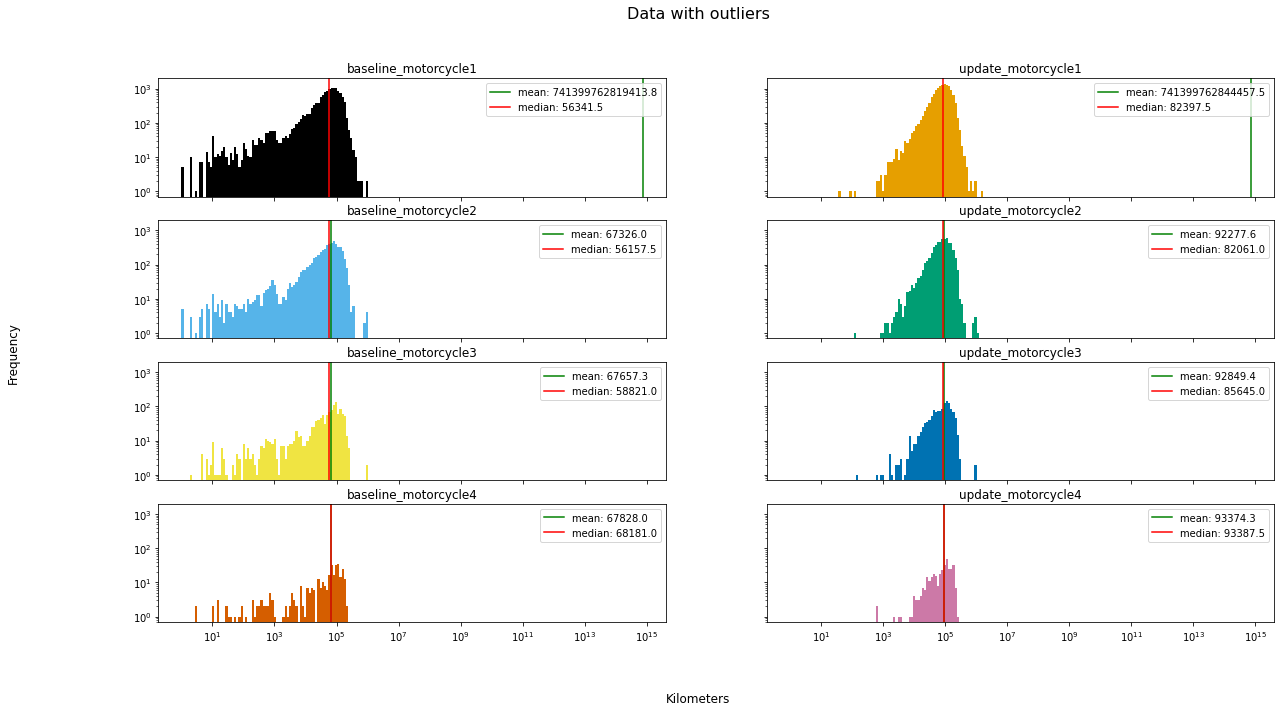

In [6]:
# 2.3a Calculating mean and median of each column and visualizing data
# interleave the columns 

def plot_all_kilometrages(title):
    """
    Plots histograms of all 4 baseline and updated kilometrages.
    """
    kilo_cols = [val for pair in zip(baselines, updates) for val in pair]
    kilometrages = dataframe[kilo_cols]

    mean = kilometrages.mean(axis = 0)
    median = kilometrages.median(axis = 0)

    fig, axs = plt.subplots(4,2, sharex = True, sharey = True, figsize = (20,10))
    fig.suptitle(title, fontsize=16)

    for i, ax in enumerate(axs.flat):
        data = dataframe[kilo_cols[i]].values
        ax.hist(data, color = colours[i], bins=np.logspace(0, np.log10(10**7), 100))
        ax.set_xscale('log')
        ax.set_yscale('log')    
        
        ax.set_title(kilo_cols[i])
        ax.axvline(mean[i], color = 'green', label = f"mean: {np.round(mean[i], 1)}")
        ax.axvline(median[i], color = 'red', label = f"median: {np.round(median[i], 1)}")
        ax.legend()

    fig.supxlabel("Kilometers")
    fig.supylabel("Frequency")

plot_all_kilometrages(title='Data with outliers')

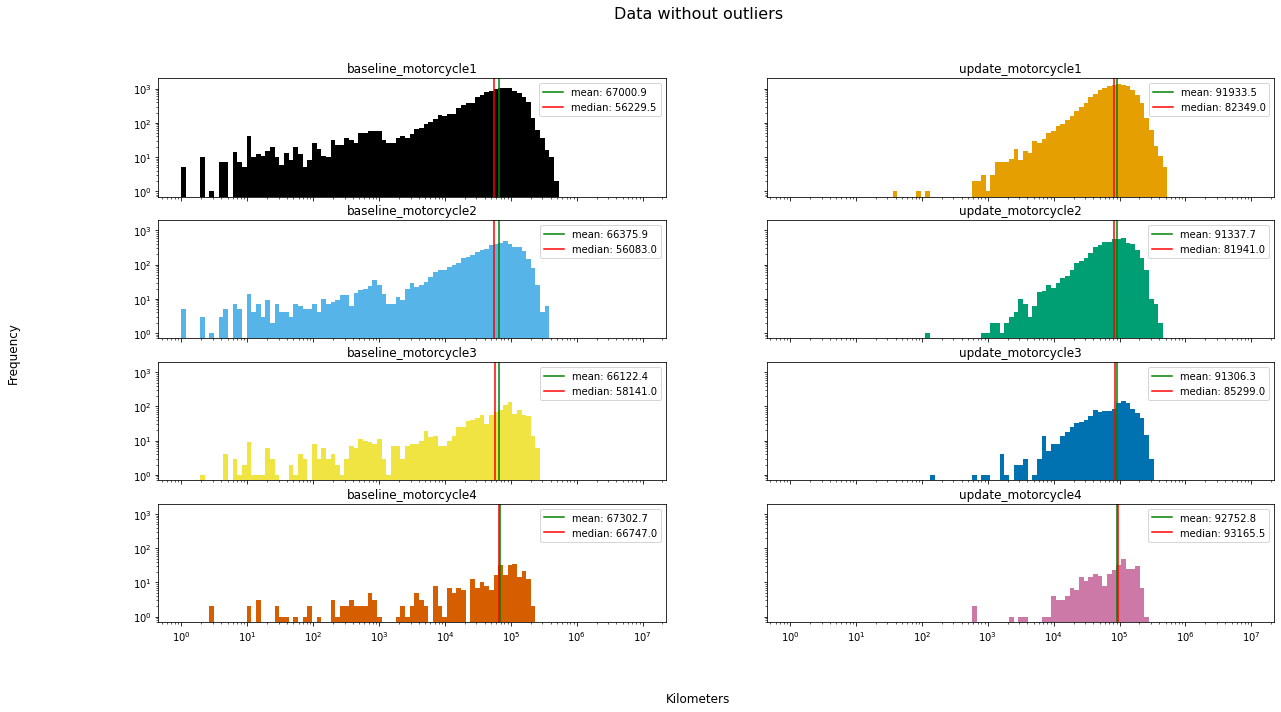

In [7]:
# 2.3b Dropping outliers, data inside 1-percent quantile and outside 99-percent quantile, and visualizing data

def remove_outliers(df, cols, bottom_percentile, upper_percentile):
    """
    In the given DataFrame, remove rows where the specified column values don't fall between the percentile bounds.
    """
    Q1 = df[cols].quantile(bottom_percentile)
    Q3 = df[cols].quantile(upper_percentile)
    IQR = Q3 - Q1

    df = df[~((df[cols] < (Q1 - 1.5 * IQR)) |(df[cols] > (Q3 + 1.5 * IQR))).any(axis=1)]
    return df
    

dataframe = remove_outliers(dataframe, baselines+updates,0.01,0.99)

plot_all_kilometrages(title='Data without outliers')

### 2.4
Since the outliers are only a few and their values are extreme, it would be better to represent data with the median, as it is less influenced by the value of those outliers (more robust).


### Task 3 — 12pts

One of the challenges with the current data is that it is not clear how to handle policies with multiple motorcycles.

1. Create three additional columns in the dataframe, `baseline_average`, `update_average`, and `diff_average`. These 
    should contain, respectively, the average value for `baseline_motorcycle[1-4]` for all motorcycles insured; the average
    value for `update_motorcycle[1-4]`; and the difference between the average updated value and the average baseline 
    value.
2. **Discuss:** Propose another way of aggregating distinct motorcycles from a single policy. Point out a way in which 
    this aggregation may be either better or worse than taking the average for the purpose of comparing the two scenarios in
    the study (sign at the top vs. sign at the bottom).
3. To get a sense of the impact that policies with multiple motorcycles may have in the study, let's perform some 
    additional analyses. Plot the distribution of motorcycles per policy in the data. Your plot should allow for the 
    meaningful comparison of the values shown.
4. In 3.1, you calculated the average kilometrage for each policy for the updated contract. Calculate the mean and the 
    standard deviation of these values (which should be in the column `update_average`).
5. Another meaningful metric is the average kilometrage **per motorcycle**, not distinguishing motorcycles in different 
    policies (i.e., pooled across policies). **Considering only policies with 4 motorcycles insured,** calculate the mean 
    and the standard deviation of the kilometrage per motorcycle in the updated contract.
6. **Discuss:** To analyze whether signing at the top decreases dishonesty, we could consider the data in different 
    ways. We could first calculate the average value per motorcycle within each policy and have one data point per policy **or** we could analyze the data at the motorcycle level and have one data point per motorcycle in the dataset. 
    According to questions 3.4 and 3.5, how may this decision influence the results of the study?
---

In [8]:
# 3.1 Creating additional columns
dataframe['baseline_average'] = dataframe[baselines].mean(axis = 1)
dataframe['update_average'] = dataframe[updates].mean(axis = 1)
dataframe['diff_average'] = dataframe['update_average'] - dataframe['baseline_average']

### 3.2  
We could calculate the median value for both baseline and update average. Median could be better because,as stated before, it would be more robust to outliers and, calculating the average of the medians would give more significant values. In this case  though, outliers have already been removed so it wouldn't make much difference. 
Another kind of aggregation might be the difference between the sum of updated values and the sum of baseline values. This gives the actual amount of kilometres percurred in a year by the person interested by the insurance policy. Results aren't much different, but if previously the difference between signed at the top and signed at the bottom averages in updated policies was 2427, now it increased to 3327. This gives us an even stronger proof that signed at the bottom documents have lower kilometrage's values. 

In [9]:
#3.2 proof
dataframe['diff_sum']= abs(dataframe[updates].sum(axis=1)-dataframe[baselines].sum(axis=1))
print(dataframe.groupby('condition').agg('mean')['diff_sum'])
print(dataframe.groupby('condition').agg('mean')['diff_average'])
dataframe=dataframe.drop('diff_sum', axis= 1)

condition
Sign Bottom    36677.924545
Sign Top       40004.264995
Name: diff_sum, dtype: float64
condition
Sign Bottom    23673.122877
Sign Top       26100.566078
Name: diff_average, dtype: float64


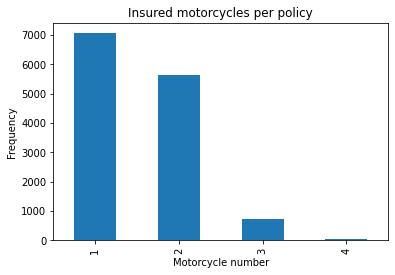

In [10]:
# 3.3 Distribution of number of motorcycles
axs = dataframe['motorcycle_count'].value_counts().plot.bar();
plt.title("Insured motorcycles per policy")
axs.set_xlabel("Motorcycle number")
axs.set_ylabel("Frequency");

In [11]:
# 3.4 Calculating mean and standard deviation for average kilometrage per updated policy
update_average_mean, update_average_sd = dataframe['update_average'].agg(['mean', 'std'])

print(f"""Average kilometrage per updated policy -
    mean: {update_average_mean:.0f} km
    sd: {update_average_sd:.0f} km
    normalized_sd: """ + str(update_average_sd/update_average_mean))

Average kilometrage per updated policy -
    mean: 91721 km
    sd: 49860 km
    normalized_sd: 0.5436077467063912


In [12]:
# 3.5 Calculating mean and standard deviation for kilometrage per motorcycle (considering updated policies with 4 motorcycles only)
kilometrage_mean, kilometrage_sd = dataframe[dataframe['motorcycle_count'] == 4][updates].agg(['mean', 'std']).values

for i, (mn, sd) in enumerate(zip(kilometrage_mean, kilometrage_sd)):
    print(f"""Average kilometrage motorcycle {i+1} -
    mean: {mn :.0f} km
    sd: {sd :.0f} km
    normalized_sd: """ + str(sd/mn))
    

Average kilometrage motorcycle 1 -
    mean: 67635 km
    sd: 42535 km
    normalized_sd: 0.6288919596617312
Average kilometrage motorcycle 2 -
    mean: 121408 km
    sd: 74218 km
    normalized_sd: 0.6113129874621938
Average kilometrage motorcycle 3 -
    mean: 103314 km
    sd: 64274 km
    normalized_sd: 0.6221203642074731
Average kilometrage motorcycle 4 -
    mean: 129108 km
    sd: 45750 km
    normalized_sd: 0.3543531044069662


### 3.6
Considering one data point per policy is better, since we obtain more homogeneous data with a lower standard deviation.

Looking at values from question __3.5__ doesn't make sense because they are calculated considering only policies with 4 motorcycles,which constitute only a small part of the dataset (as we can see in question __3.3__). If we calculate the same values considering all policies we obtain similar averages and similar standard deviations, all higher than the standard deviation obtained by consider one data point per policy.
 
We might instead divide the policies into four populations, based on `motorcycle_count`. This way we can then calculate the average difference between updated policies and baseline ones, dividing the result among signing position of the updated policies. Dividing the data into four populations considering one data point per motorcycle is also worse because populations wouldn't be independent, since kilometrage values of motorcycles from the same policy are all from the same document with the same signing position.  

On the other hand, this decision would probably not influence the result of the study, since both ways prove that signed at the top documents have always sligthly lower values.

In [13]:
#proof and calculus to support 3.6
kilometrage_mean, kilometrage_sd = dataframe[updates].agg(['mean', 'std']).values
for i, (mn, sd) in enumerate(zip(kilometrage_mean, kilometrage_sd)):
    print(f"""Average kilometrage motorcycle {i+1} -
    mean: {mn :.0f} km
    sd: {sd :.0f} km
    normalized_sd: """ + str(sd/mn))
policy_type = ["Sign Bottom", "Sign Top"]

print(dataframe.groupby(['condition','motorcycle_count']).agg('mean')['diff_average'])
dataframe['diff_of_1']= dataframe[updates[0]]-dataframe[baselines[0]]
print(dataframe.groupby('condition').agg('mean')['diff_of_1'])
dataframe['diff_of_2']= dataframe[updates[1]]-dataframe[baselines[1]]
print(dataframe.groupby('condition').agg('mean')['diff_of_2'])
dataframe['diff_of_3']= dataframe[updates[2]]-dataframe[baselines[2]]
print(dataframe.groupby('condition').agg('mean')['diff_of_3'])
dataframe['diff_of_4']= dataframe[updates[3]]-dataframe[baselines[3]]
print(dataframe.groupby('condition').agg('mean')['diff_of_4'])



Average kilometrage motorcycle 1 -
    mean: 91934 km
    sd: 56558 km
    normalized_sd: 0.6152009067934034
Average kilometrage motorcycle 2 -
    mean: 91338 km
    sd: 55240 km
    normalized_sd: 0.604786183154566
Average kilometrage motorcycle 3 -
    mean: 91306 km
    sd: 57938 km
    normalized_sd: 0.6345414902225907
Average kilometrage motorcycle 4 -
    mean: 92753 km
    sd: 55957 km
    normalized_sd: 0.603292239900256
condition    motorcycle_count
Sign Bottom  1                   23276.944780
             2                   24048.274373
             3                   24602.005479
             4                   23282.476190
Sign Top     1                   26179.650279
             2                   26037.316445
             3                   25802.350638
             4                   26405.964286
Name: diff_average, dtype: float64
condition
Sign Bottom    23622.255073
Sign Top       26211.199589
Name: diff_of_1, dtype: float64
condition
Sign Bottom    24151.0399

### Task 4 — 18pts

Now that we have compressed the kilometrage reported in each contract into a single number, it is time to analyze the 
million-dollar question: ***does signing at the top decrease dishonesty?***

1. Considering the updated contracts, calculate the mean and the standard deviation of the average kilometrage in 
    1. policies where the signing was done at the bottom; and 
    2. policies where the signing was done at the top. Additionally, plot the two kilometrage distributions.
2. Determine whether the difference between the two scenarios mentioned in 1. is statistically significant.
3. **Discuss:** Recall that the assignment of the different contracts (*sign at the top* vs. *sign at the bottom*) was 
    done at random. According to the results in 1. and 2., does signing at the top decrease dishonesty? 
4.  **Discuss:** Given that no intervention was performed in the baseline contract (i.e., everyone signed at the 
    bottom). Would you expect any differences between the average values between *sign at the top* vs. *sign at the bottom*
    conditions for the baseline contract? Note that this is related to columns `baseline_motorcycle[1-4]`.
5. Calculate the mean and the standard deviation for the baseline contracts of the two groups (sign at the top vs. sign 
    at the bottom). Additionally, plot the two kilometrage distributions.
6. Determine whether the difference between the two scenarios mentioned in 5. is statistically significant.

---

**Hint:** Recall that the column `condition` encodes the experimental condition in which the customer fell when 
reporting the values shown in columns `update_motorcycle[1-4]`!

**Hint:** To determine if the means of two sets of data are significantly different from each other, you may want to use
 the `ttest_ind` function implemented in the 
 [scipy library](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html). To learn more about 
 Student's t-test, check out this [Wikipedia page](https://en.wikipedia.org/wiki/Student%27s_t-test).

In [14]:
def plot_mean_std(ax, mean, std):
    """
    Adds the mean and standard deviation lines to the given axes of a plot.
    """
    lower, upper = mean - std, mean + std
    ax.axvspan(lower, upper, alpha=0.15, color='red')
    ax.axvline(lower, linestyle = "--", color = 'red', label = 'mean - std: '+ str(np.round(lower, 1)))
    ax.axvline(upper, linestyle = "--", color = 'red', label = 'mean + std: '+ str(np.round(upper, 1)))
    ax.axvline(mean, color = 'orange', label = 'mean: '+ str(np.round(mean, 1)))

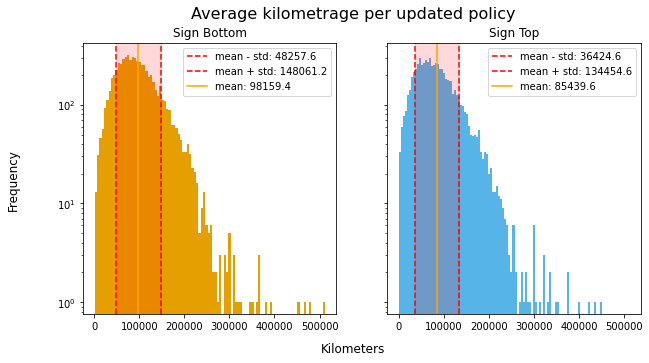

In [15]:
# 4.1 mean and std for average kilometrage per updated policy and seperated on condition

policy_type = ["Sign Bottom", "Sign Top"]

# for each condition, aggregate the mean and standard deviation of the average kilometrage per updated policy
mean, std = dataframe.groupby('condition')['update_average'].agg(['mean', 'std']).T.values

fig, axs = plt.subplots(1,2, sharex = True, sharey = True, figsize = (10,5))
fig.suptitle('Average kilometrage per updated policy', fontsize=16)

for i, ax in enumerate(axs.flat):
    ax.hist(dataframe[dataframe['condition'] == policy_type[i]]['update_average'].values, bins = 100, color = colours[i+1])
    ax.set_yscale('log')
    ax.set_title(policy_type[i])
    
    # plot std as a range around the mean
    plot_mean_std(ax, mean[i], std[i])
    ax.legend()



fig.supxlabel("Kilometers")
fig.supylabel("Frequency");

In [16]:
# 4.2 Testing if the two independent datasets of 'updated contract kilometrage' have identical average values using the ttest_ind function from scipy
from scipy.stats import ttest_ind

ttest_ind(
    dataframe[dataframe['condition'] == policy_type[0]]['update_average'].values,
    dataframe[dataframe['condition'] == policy_type[1]]['update_average'].values
    )

Ttest_indResult(statistic=14.925373355138145, pvalue=5.650578748070613e-50)

### 4.2 
`p_value` is less than 0.05, therefore we reject the null hypothesis that the kilometrages are the same, there is a significant difference.

### 4.3
The `p_value` is less than 0.05, therefore we can reject the null hypothesis that the kilometrages are the same. This means that there is a significant difference between the two populations.

Considering this and that contracts signed at the bottom have a remarkable higher kilometrage, we can assume that signing at the top does indeed decrease dishonesty.

### 4.4
We would expect a statistically insignificant difference in the average kilometrage among the baseline contracts, since the Signed Bot vs Signed Top difference didn't exist in those contracts, i.e. they should be part of the same population.

Text(0.02, 0.5, 'Frequency')

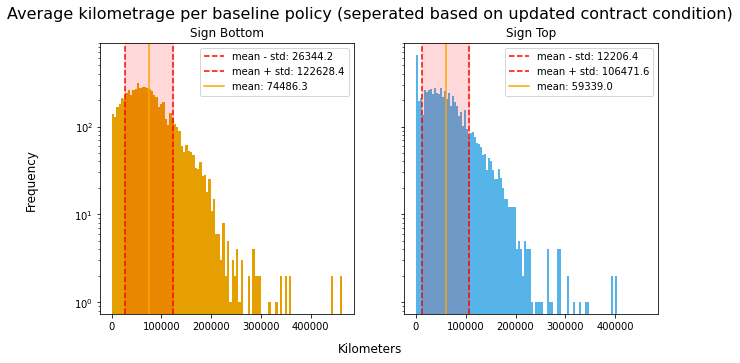

In [17]:
# 4.5 mean and std for average kilometrage per baseline policy and seperated on condition

policy_type = ["Sign Bottom", "Sign Top"]

# for each condition, aggregare the mean and standard deviation of the average baseline kilometrage per contract
mean, std = dataframe.groupby('condition')['baseline_average'].agg(['mean', 'std']).T.values

fig, axs = plt.subplots(1,2, sharex = True, sharey = True, figsize = (10,5))
fig.suptitle('Average kilometrage per baseline policy (seperated based on updated contract condition)', fontsize=16)

for i, ax in enumerate(axs.flat):
    ax.hist(dataframe[dataframe['condition'] == policy_type[i]]['baseline_average'].values, bins = 100, color = colours[i+1])
    ax.set_yscale('log')
    ax.set_title(policy_type[i])
    plot_mean_std(ax, mean[i], std[i])
    ax.legend()

fig.supxlabel("Kilometers")
fig.supylabel("Frequency")

In [18]:
# 4.6 Testing if the two independent datasets of 'baseline contract kilometrage' have identical average values using the ttest_ind function from scipy
from scipy.stats import ttest_ind

ttest_ind(
    dataframe[dataframe['condition'] == policy_type[0]]['baseline_average'].values,
    dataframe[dataframe['condition'] == policy_type[1]]['baseline_average'].values
    )

Ttest_indResult(statistic=18.453226727861935, pvalue=4.1293195903442773e-75)

### 4.6 
`p_value` is less than 0.05, therefore we reject the null hypothesis that the kilometrages are the same, there is a significant difference.

## Interlude: Something is dodgy about this data...

---

Noticing the oddities in the data, you send an email to your contact at the insurance company asking about the integrity
 of the data. Their reply seems like something out of a detective movie:

> Dear researcher, I believe that this data is not to be trusted. I can't talk right now but will send further hints 
>throughout the week.

As a researcher, you know that [data integrity](https://en.wikipedia.org/wiki/Data_integrity) is a big deal, and decide
 to investigate.

### Task 5 — 9pts

The first hint you receive is: *there is something off about the kilometrage values in the data.*

1. For the baseline contract and for the updated contract, plot the distribution of odometer kilometrage reported for 
    the first motorcycle insured in each policy. 
2. For the first motorcycle insured by the company in each policy, plot the difference between the number of kilometers
    reported in the baseline and in the updated contract.
3. **Discuss:** why is this data unlikely to have originated from real odometer readings?

---

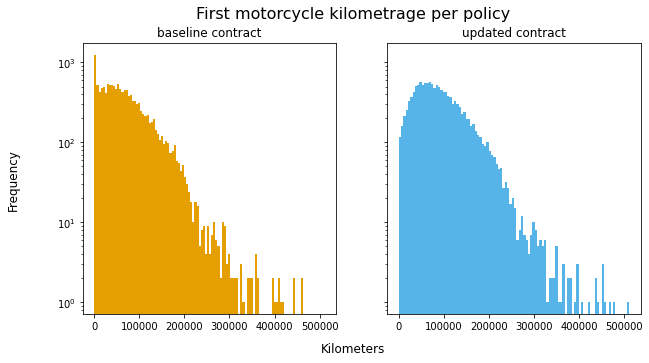

In [19]:
# 5.1 Plotting the updated and baseline kilometrage for the first motorcycle of each policy

contract_type = ['baseline contract', 'updated contract']

kilometrages = [dataframe[baselines[0]], dataframe[updates[0]]]

fig, axs = plt.subplots(1,2, sharex = True, sharey = True, figsize = (10,5))
fig.suptitle('First motorcycle kilometrage per policy', fontsize=16)

for i, ax in enumerate(axs.flat):
    ax.hist(kilometrages[i].values, bins = 100, color = colours[i+1])
    ax.set_yscale('log')
    ax.set_title(contract_type[i])

fig.supxlabel("Kilometers")
fig.supylabel("Frequency");

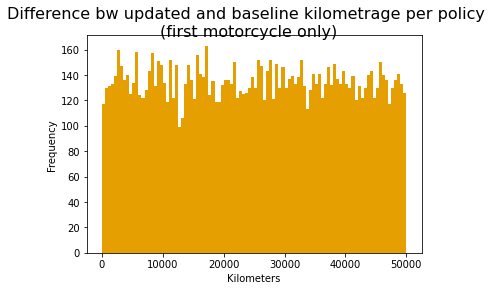

In [20]:
# 5.2 Plotting the difference in updated and baseline kilometrage for the first motorcycle of each policy

kilometrages_diff = dataframe[updates[0]] - dataframe[baselines[0]]

plt.hist(x=kilometrages_diff, bins=100, color=colours[1])
plt.suptitle('Difference bw updated and baseline kilometrage per policy \n(first motorcycle only)', fontsize=16)
plt.xlabel("Kilometers")
plt.ylabel("Frequency");

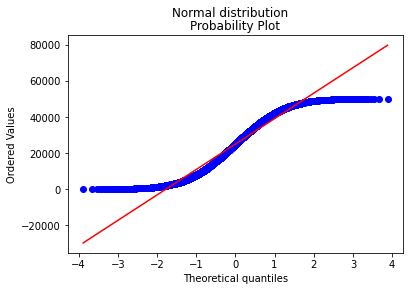

In [21]:
stats.probplot(kilometrages_diff, dist='norm', plot=plt)

plt.suptitle("Normal distribution");

### 5.3 
We would expect the data in the histogram above to follow a normal distribution (bell curve), but it doesn't, as it can be seen in the probplot above.  

A smaller number of people should have used their motorcycle very little or very much, in the duration between the baseline and updated contract, while the large majority of people would have driven the motorcycles around some average distance. Instead, we can see how the population seems to follow some sort of uniform distribution, which is unlikely.

### Task 6 — 15pts

The second hint you receive is: *there is something off with the last digits of the reported kilometrages.*

1. Considering the baseline kilometrage of the first motorcycle in each contract (`baseline_motorcycle1`), plot the 
    distribution of occurrences of the last three digits. Repeat the same for the updated kilometrage of the first 
    motorcycle in each contract (`update_motorcycle1`).

3. **Discuss:** What are the differences between the two distributions?

4. **Discuss:** Hypothesize a **plausible** cause for the patterns observed in the digit distribution of the baseline
    kilometrage of the first motorcycle.
    
---

**Hint:** The last three digits of the number 12314 are 314. Note that you should consider the three last digits together,
 not separately!

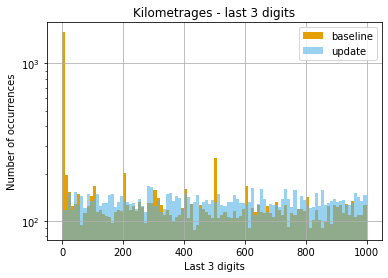

Value counts for the baseline: 
 0      1397
500     143
200      73
600      64
100      57
Name: baseline_motorcycle1, dtype: int64
Value counts for the update: 
 60     26
738    25
517    24
902    24
980    23
Name: update_motorcycle1, dtype: int64


In [22]:
# 6.1 Plotting the distribution of occurrences of the last three digits

def plot_3digits(data1, data2, title, label1, label2):
    """
    Plot the distribution of last three digits in the values of the two provided Series.
    """
    # calculate last 3 digits of the kilometrages using the modulo operator
    data1_last3digits = data1 % 1000
    data2_last3digits = data2 % 1000

    # construct the plot
    plt.yscale("log")
    plt.title(title)
    plt.xlabel("Last 3 digits")
    plt.ylabel("Number of occurrences")

    # plot the histograms
    data1_last3digits.hist(bins = 100, alpha = 1, label = label1, color=colours[1])
    data2_last3digits.hist(bins = 100, alpha = 0.6, label = label2, color=colours[2])

    # show the plot
    plt.legend()
    plt.show()

    # to support the plot, please see the most common values:
    print("Value counts for the baseline: \n", data1_last3digits.value_counts().iloc[:5])
    print("Value counts for the update: \n", data2_last3digits.value_counts().iloc[:5])

plot_3digits(dataframe["baseline_motorcycle1"], dataframe["update_motorcycle1"], "Kilometrages - last 3 digits", "baseline", "update")

### 6.2
The last 3 digits of the `update_motorcycle1` column follow a uniform distribution. The last 3 digits of the `baseline_motorcycle1` column also follow a distribution close to normal, with an exception of some clearly visible peaks: the largest one is for value `000` and some other peaks around all the other 'round' numbers (`100`, `200`, ..., `900`).

### 6.3
The large peak around `000` may be a result of people registering new motorcycles with no kilometrage yet. The peaks around 'round' numbers can be explained as follows: it is possible that some users entered approximate, rounded values for the baseline contract, which would explain the peaks in the histogram for `baseline_motorcycle1`. On the other hand, for the contract update, the first motorcycle does not have a peak around 0 anymore because none of the motorcyles are new, all of them have already had a previous contract i.e. have been driven already. Moreover, the users were explicitly asked to report the *'exact odometer kilometrage'*, so the peaks for the round values  in the histogram for `update_motorcycle1` are gone and the values follow the expected uniform distribution.

### Task 7 — 15pts

The third (and last) hint you receive is: *there is something wrong with the fonts.*

Your anonymous source explains that the `.tsv` file sent to you was derived from an Excel sheet. There, some of the rows
 were written in the font *Helvetica* while others were written in the font *Arial*. Your anonymous source sends you a 
 file with the relation between policy id and the font used in the respective row (`fonts.csv`), and tells you that the
  rows with *Helvetica* font were fabricated.

1. Load `fonts.csv` and merge the `font` column into your pandas dataframe.
2. Considering only the kilometrage of the first motorcycle in each policy, calculate the number of rows with the Arial  and the Helvetica font, respectively. Also, plot the distribution of baseline kilometers for rows with the Arial font  and for rows with the Helvetica font.
3. Similar to what was done in task 6. Plot the distribution of the last three digits for 1) the first motorcycle in  each baseline contract (`baseline_motorcycle1`); and 2) the first motorcycle in each updated contract  (`update_motorcycle1`).
4. **Discuss:** Why do these analyses provide evidence that the rows with Helvetica font were fabricated?

---

In [23]:
# 7.1 Load fonts.csv and merge the font column into your pandas dataframe.

# load the data
fonts = pd.read_csv("data/fonts.csv")
fonts = fonts.set_index('id')

# and perform the join
dataframe = dataframe.join(fonts, on='id', how='left')
dataframe.head()

,condition,id,baseline_motorcycle1,update_motorcycle1,baseline_motorcycle2,update_motorcycle2,baseline_motorcycle3,update_motorcycle3,baseline_motorcycle4,update_motorcycle4,motorcycle_count,baseline_average,update_average,diff_average,diff_of_1,diff_of_2,diff_of_3,diff_of_4,font
0,Sign Top,1,896,39198,NaN,NaN,NaN,NaN,NaN,NaN,1,896.0,39198.0,38302.0,38302,NaN,NaN,NaN,Helvetica
1,Sign Bottom,2,21396,63511,32659.0,47605.0,NaN,NaN,NaN,NaN,2,27027.5,55558.0,28530.5,42115,14946.0,NaN,NaN,Helvetica
2,Sign Bottom,3,21340,37460,44998.0,59002.0,NaN,NaN,NaN,NaN,2,33169.0,48231.0,15062.0,16120,14004.0,NaN,NaN,Helvetica
3,Sign Bottom,4,23912,59136,NaN,NaN,NaN,NaN,NaN,NaN,1,23912.0,59136.0,35224.0,35224,NaN,NaN,NaN,Helvetica
4,Sign Bottom,5,16862,59292,NaN,NaN,NaN,NaN,NaN,NaN,1,16862.0,59292.0,42430.0,42430,NaN,NaN,NaN,Arial


In [24]:
# 7.2 Considering only the kilometrage of the first motorcycle in each policy, calculate the number of rows with the Arial.

# split the data, check the number of rows
arial = dataframe[dataframe['font'] == 'Arial']
helvetica = dataframe[dataframe['font'] == 'Helvetica']

print(f"""Number of rows:
    Arial:       {arial.shape[0]}
    Helvetica:   {helvetica.shape[0]}""")

Number of rows:
    Arial:       6737
    Helvetica:   6735


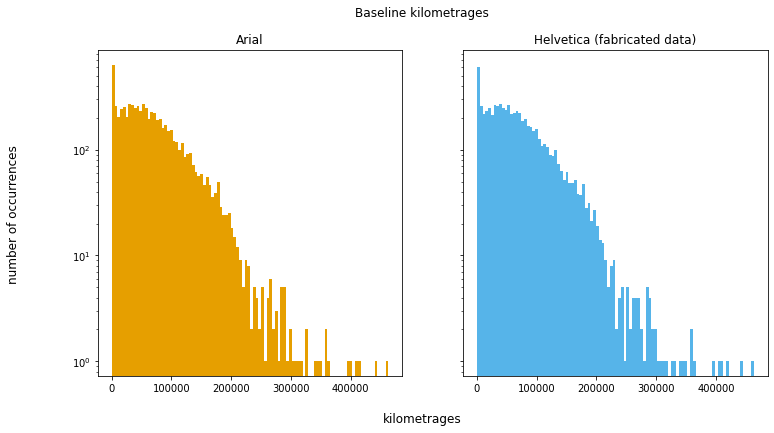

In [25]:
# Also, plot the distribution of baseline kilometers for rows with the Arial font and for rows with the Helvetica font. 

def plot_hist_array(title, datas, labels, xlabel, ylabel):
    """
    Plot histograms for the array of data series provided with respective labels.
    """
    assert len(datas) == len(labels), "The number of data lists and labels has to be the same."
    N = len(datas)

    fig, axs = plt.subplots(1,N, sharex = True, sharey = True, figsize = (N * 6,6))
    fig.suptitle(title, fontsize=12)

    for ax, data, label, color in zip(axs.flat, datas, labels, colours[1:]):
        ax.hist(data.values, bins = 100, color = color)
        ax.set_yscale('log')
        ax.set_title(label)

    fig.supxlabel(xlabel)
    fig.supylabel(ylabel);

datas = [arial["baseline_motorcycle1"], helvetica["baseline_motorcycle1"]]
labels = ["Arial", "Helvetica (fabricated data)"]
plot_hist_array("Baseline kilometrages", datas, labels, "kilometrages", "number of occurrences")


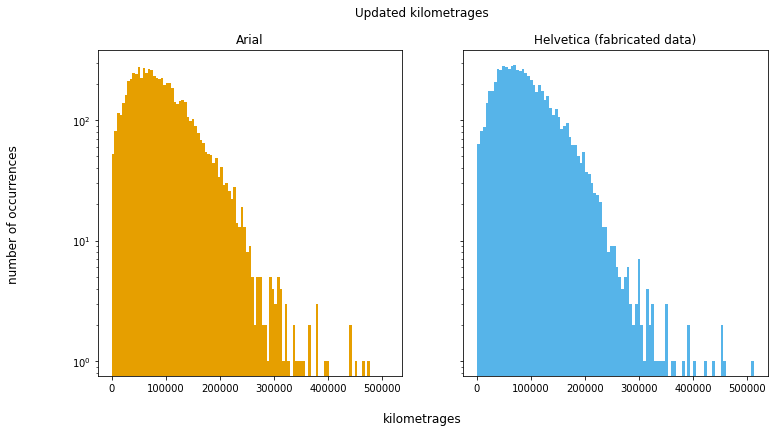

In [26]:
# Also plot the update
datas = [arial["update_motorcycle1"], helvetica["update_motorcycle1"]]
labels = ["Arial", "Helvetica (fabricated data)"]
plot_hist_array("Updated kilometrages", datas, labels, "kilometrages", "number of occurrences")

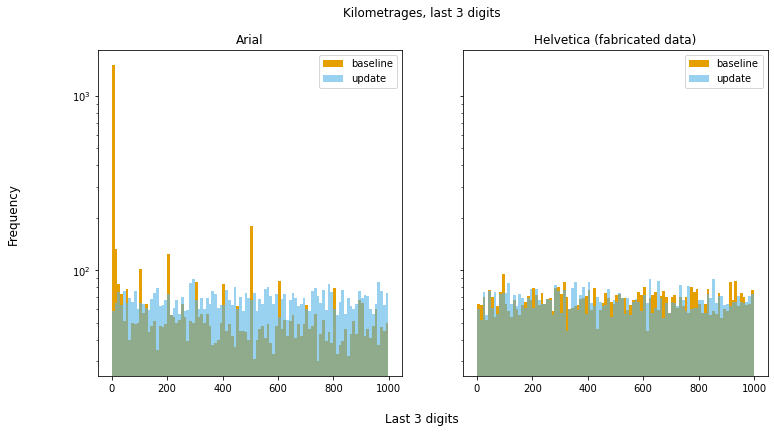

In [27]:
#  7.3 Similar to what was done in task 6. Plot the distribution of the last three digits for 
#       1) the first motorcycle in each baseline contract (baseline_motorcycle1); and 
#       2) the first motorcycle in each updated contract (update_motorcycle1).

def compare_3_digits(title, xlabel, ylabel, baseline1, update1, label1, baseline2, update2, label2):
    fig, axs = plt.subplots(1, 2, sharex = True, sharey = True, figsize = (12,6))
    fig.suptitle(title, fontsize=12)

    for ax, baseline, update, label, color in zip(axs.flat, [baseline1, baseline2], [update1, update2], [label1, label2], colours):
        ax.set_yscale('log')
        ax.set_title(label)
        ax.hist(baseline, bins = 100, alpha = 1, label = "baseline", color=colours[1])
        ax.hist(update, bins = 100, alpha = 0.6, label = "update", color=colours[2])
        ax.legend()
    
    fig.supxlabel(xlabel)
    fig.supylabel(ylabel);

compare_3_digits("Kilometrages, last 3 digits", "Last 3 digits", "Frequency", 
arial["baseline_motorcycle1"] % 1000, arial["update_motorcycle1"] % 1000 , "Arial",
helvetica["baseline_motorcycle1"] % 1000, helvetica["update_motorcycle1"] % 1000, "Helvetica (fabricated data)")

#### 7.4
__Q: Why do these analyses provide evidence that the rows with Helvetica font were fabricated?__

Suspiciously, the *baseline* and *update* distributions seem almost identical for Arial and Helvetica -- it seems like someone has taken the data from Arial, and generated more data following the same distribution. To support this theory, consider the last 3 digits plots: in the first plot (for the Arial distribution), we can observe the difference between the *baseline* and the *update* distributions, explained in tasks __6.3__ and __6.4__ - the *baseline* has several peaks, but the *update* follows a uniform distribution. However, for the Helvetica data there is no such effect, indicating that the data was generated automatically for both *baseline* and *update* columns.

<!-- TODO: finish -->

### Task 8 — 15pts

You've had enough! You decide to write an email to your PI (principal investigator, also known as "your boss") reporting
 the oddities you have observed in the data. Write a (brief) text (in markdown) of up to 300 words. Your text should:

- Use the analyses you did to make a convincing case that the data has been tampered with. 
- Grounded in your analyses, provide a plausible hypothesis about how the data has been tampered with.
- Discuss whether the data leads to the conclusion that signing at the top decreases dishonesty.

Structure your text into three bullets, analogous to the ones above.

You can reference images present in the notebook by indicating a task (e.g., image plotted in Task 3.3) or a cell 
number.

Note that you do not need to conduct any additional analysis to write this text. If you do, the code should be at the 
end of this notebook, i.e., after your answer.

---

**Hint:** The data has been tampered with in more than one way.

### The data is not convincing
- The data provided for the study can not be used since different analyses prove that it has been tampered with. Firstly, kilometrage differences between updated and baseline policies follow a uniform distribution. This is highly suspect since people's usage of motorcycles should be around the average, and only a few travel a lot or little (normal distribution). Additionally, some policies were written using “Helvetica” font, whereas others used “Arial”. Dividing the data according to the font we find two identically distributed populations but radical differences in the last 3-digits. Arial-written data mostly have kilometrages rounded to “000”, as well as “200”,”300”, etc. Conversely, Helvetica’s data is equally distributed among all 3-digits numbers. Finally, statistical hypothesis tests prove that, dividing baseline kilometrages by the policy’s signing position, we obtain two populations with different means, even though all baseline policies had to be signed at the bottom and should have had, therefore, an equal mean. Considering only Arial-written data doesn’t change the result.
- Due to what was stated above, some hypotheses might be made. According to the 3 digits distribution, Helvetica’s data has been generated following real data distribution, but without considering the human’s tendency to round values. This tendency disappears in updated values since *'exact odometer kilometrage'* were asked. Even without considering Helvetica’s data, many signed at the top policies have null baseline kilometrage values, whereas policies signed at the bottom don’t. This may contradict the claim that updated policies were divided randomly among baseline contracts.
- To conclude, data insights seem to prove that signing at the top decreases dishonesty with slightly higher values in kilometrage declarations. On the other hand, since policies appear to come from different populations, we can’t state that data is telling the truth. Therefore, nothing can be proved.


Text(0, 0.5, 'Frequency')

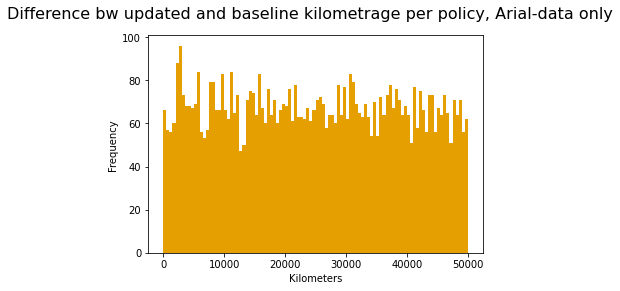

In [28]:
# Task 8 Additional analysis 

dataframe = dataframe.drop(dataframe[dataframe.font == 'Helvetica'].index)
kilometrages_diff = dataframe[updates[0]] - dataframe[baselines[0]]
plt.hist(x=kilometrages_diff, bins=100, color=colours[1])
plt.suptitle('Difference bw updated and baseline kilometrage per policy, Arial-data only', fontsize=16)
plt.xlabel("Kilometers")
plt.ylabel("Frequency")

Test to show that Helvetica and Arial populations have the same average value :

baseline_1 kilometrages : Ttest_indResult(statistic=-0.5078907625572127, pvalue=0.6115382695303345)
updated_1 kilometrages  : Ttest_indResult(statistic=-0.865286631422312, pvalue=0.3868968965203279)

p-values > 0.05, therefore we cannot reject the null hypothesis, 
i.e. there is no statistically significant difference in the avg values.
────────────────────────────────────────────────────────────────────────────────────────────────────

Test to show that Arial-only data still has different means between baseline values seperated by sign position :

Ttest_indResult(statistic=12.69568787359053, pvalue=1.6333976432950103e-36)

p-values < 0.05, therefore we can reject the null hypothesis, 
i.e. there is a statistically significant difference in the avg values.
────────────────────────────────────────────────────────────────────────────────────────────────────


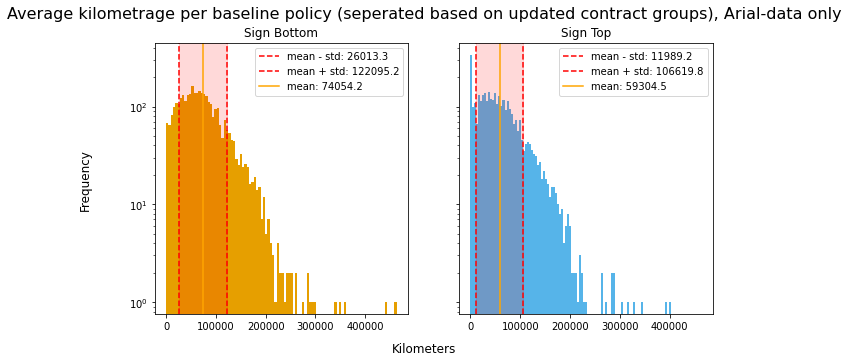

In [29]:

print(f"""Test to show that Helvetica and Arial populations have the same average value :

baseline_1 kilometrages : {ttest_ind(arial[baselines[0]].values, helvetica[baselines[0]].values)}
updated_1 kilometrages  : {ttest_ind(arial[updates[0]].values, helvetica[updates[0]].values)}

p-values > 0.05, therefore we cannot reject the null hypothesis, 
i.e. there is no statistically significant difference in the avg values.""")
print(u'\u2500' * 100)


print(f"""\nTest to show that Arial-only data still has different means between baseline values seperated by sign position :

{ttest_ind(
    arial[arial['condition'] == policy_type[0]]['baseline_average'].values,
    arial[arial['condition'] == policy_type[1]]['baseline_average'].values)}

p-values < 0.05, therefore we can reject the null hypothesis, 
i.e. there is a statistically significant difference in the avg values.""")
print(u'\u2500' * 100)


policy_type = ["Sign Bottom", "Sign Top"]

# per condition, aggregate mean and standard deviation for average kilometrages per baseline policy
mean, std = dataframe.groupby('condition')['baseline_average'].agg(['mean', 'std']).T.values

fig, axs = plt.subplots(1,2, sharex = True, sharey = True, figsize = (10,5))
fig.suptitle('Average kilometrage per baseline policy (seperated based on updated contract groups), Arial-data only', fontsize=16)

for i, ax in enumerate(axs.flat):
    ax.hist(dataframe[dataframe['condition'] == policy_type[i]]['baseline_average'].values, bins = 100, color = colours[i+1])
    ax.set_yscale('log')
    ax.set_title(policy_type[i])
    plot_mean_std(ax, mean[i], std[i])
    ax.legend()

fig.supxlabel("Kilometers")
fig.supylabel("Frequency");

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=a25aa466-a2dc-4ad4-9304-58fc6e1ed48d' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>